# Stackoverflow

In [1]:
# libraries import
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

## Configuration information used to connect to the database

In [2]:
db_config = {
    'user': 'praktikum_student', 
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, 
    'db': 'data-analyst-advanced-sql'
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
# connection
engine = create_engine(connection_string) 

In [4]:
# query sample
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 5;
'''
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700


# Task 1

Print total number of page views for each month of 2008. If there isn't data for a month, then skip it. Order the result by decreasing number of views.

In [5]:
query = '''
SELECT DATE_TRUNC('MONTH', creation_date):: DATE AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY 1
ORDER BY total_views DESC;
'''
# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


## Conclusion
The July views are much lower than in other months. Most probably because the data is not presented for the whole month. The number of views reaches its peak in September and then goes down in December. Probably a lot of employees and students leave the summer holidays and visit the site more actively. The decline in December may be due to vacation time.

# Task 2

Display the names of the most active users who gave more than 100 answers in the first month after registration (including the day of registration). Do not take into account any questions asked by users. For each user name, select the number of unique user_id values. Sort the result by names in alphabetical order.

In [6]:
query = '''
SELECT display_name,
       COUNT(DISTINCT user_id)
FROM stackoverflow.posts
JOIN stackoverflow.users ON users.id = posts.user_id
JOIN stackoverflow.post_types ON posts.post_type_id = post_types.id
WHERE post_types.type = 'Answer'
  AND (DATE_TRUNC('DAY', posts.creation_date) :: DATE BETWEEN DATE_TRUNC('DAY', users.creation_date) :: DATE 
  AND DATE_TRUNC('DAY', users.creation_date) :: DATE + INTERVAL '1 month')
GROUP BY display_name
HAVING COUNT(*) > 100;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


In [7]:
# search for anomalies
sample_df.query('count != 1')

,display_name,count
4,Alan,8
7,Brian,15
10,Chris,29
12,Craig,10
14,Dan,21
21,Greg,12
25,Jim,7
26,Joe,9
33,Josh,16
34,Keith,5


## Conclusion

By anomalies we mean repetitions in user names - i.e. one name corresponds to several IDs. This indicates that registration does not require a unique user name and can be repeated. In this case, when counting active users, the counting should be perfomed by unique ID number, not by names.

# Task 3

Display the number of posts in 2008 by months. Select posts from users who registered in September 2008 and made at least one post in December 2008. Sort by month in descending order.

In [8]:
query = '''
SELECT DATE_TRUNC('MONTH', creation_date):: DATE,
       COUNT(id)
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-01-01' AND '2008-12-31'
  AND user_id IN
    (SELECT user_id
     FROM stackoverflow.users
     JOIN stackoverflow.posts ON posts.user_id = users.id
     WHERE (users.creation_date :: DATE BETWEEN '2008-09-01' AND '2008-09-30')
       AND posts.creation_date :: DATE BETWEEN '2008-12-01' AND '2008-12-31' )
GROUP BY 1
ORDER BY 1 DESC;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


## Conclusion

Data is presented from August to December. We chose users who registered in August, so the low number of posts (32) observed in this month. The number of posts increases in September and October, and decreases in November and December, reflecting the posts trend we observed earlier.

# Task 4

Select following fields:

- user ID;
- post date;
- number of views post;
- cummulative sum of views for this author;
Data in the table must be sorted by increasing user IDs, and data on the same user must be sorted by increasing post-creation date.

In [9]:
# query
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id
                             ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY 1,
         2;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Task 5

Find the average number of posts per day in August 2008. Select data about users who posted more than 120 posts in August. Days without postings are not included.
Sort by increasing the average number of posts.

In [10]:
query = '''
SELECT user_id,
       COUNT(id):: NUMERIC / COUNT(DISTINCT creation_date :: DATE) AS avg_daily
FROM stackoverflow.posts
WHERE creation_date :: date BETWEEN '2008-08-01' AND '2008-08-31'
GROUP BY user_id
HAVING COUNT(id) > 120
ORDER BY 2;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Task 6

How many average days did users interact with the platform between 1 and 7 December 2008? For each user select the days in which he or she posted at least one post. 

In [11]:
query = '''
SELECT ROUND(SUM(days_cnt) / COUNT(*)) AS RESULT
FROM
  (SELECT user_id,
          COUNT(DISTINCT creation_date :: DATE) AS days_cnt
   FROM stackoverflow.posts
   WHERE creation_date :: DATE BETWEEN '2008-12-01' AND '2008-12-07'
   GROUP BY user_id) t;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,result
0,2.0


## Conclusion

On average, users interacted with the platform for two days per week (only the days when the user published a question or answer were counted). It is a good result, given that we did not analyze data about possible views, when the user also interact with the platform.

# Task 7

Display the activity of each user as: user ID and post date. Sort the output by increasing IDs, the data on the same user should be sorted by increasing post-creation date.

Add a new field to the table: for each post specify the month name of the second last publication. If there is no such publication, display NULL.

In [12]:
query = '''
SELECT user_id,
       creation_date,
       LAG(TO_CHAR(creation_date :: DATE, 'Month'), 2, NULL) OVER(PARTITION BY user_id
                                                                  ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY 1,
         2;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Task 8

Calculate the monthly equivalent of Retention Rate for StackOverflow users. Group into cohorts by the month of the first post. Activity determine by the post in the current month.

In [13]:
query = '''
WITH PROFILE AS
  (SELECT user_id,
          DATE_TRUNC('MONTH', MIN(creation_date)):: DATE AS cohort_dt,
          COUNT(user_id) OVER (PARTITION BY DATE_TRUNC('MONTH', MIN(creation_date)):: DATE) AS cohort_users_cnt
   FROM stackoverflow.posts
   GROUP BY user_id), sessions AS
  (SELECT DISTINCT user_id,
                   DATE_TRUNC('MONTH', creation_date):: DATE AS session_date
   FROM stackoverflow.posts
   GROUP BY 1,
            2)
SELECT cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM PROFILE p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
ORDER BY cohort_dt,
         session_date;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


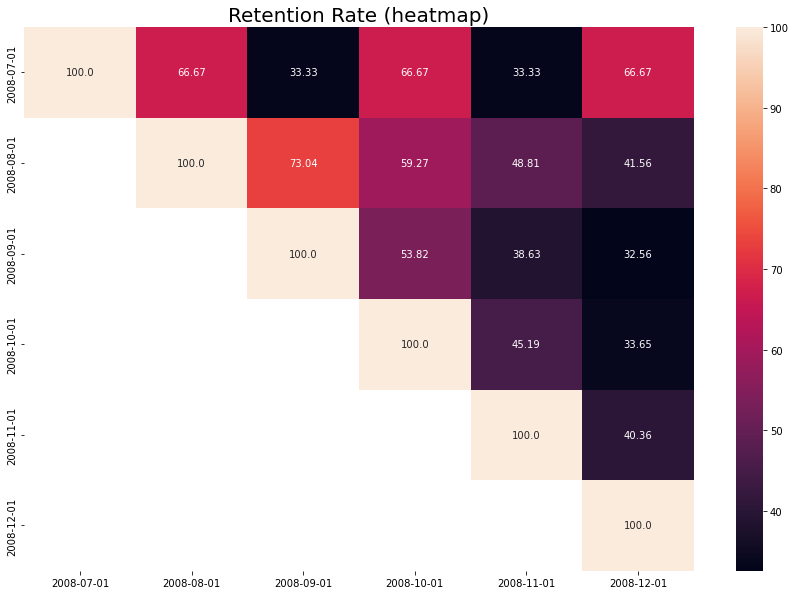

In [14]:
# visualization
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

plt.figure(figsize=(15, 10))
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Retention Rate (heatmap)', fontsize=20) 
plt.show()

## Conclusion

In the July cohort, the RR ranges from 33.33 to 66.67 (although this parameter should decline) because in October and December, the number of posts increased. In this case, for activity parameter is better to take the date of the user’s visit, because the post parameter does not reflect the full interaction with the platform. Also, the July cohort is very small (only 3 users) and not quite suitable for the RR analysis.
For the rest of the cohort, retention decreases naturally throughout the cohort’s lifetime. There was also a decline in the cohort from August through December, indicating a decline in user interest in the platform over time.

# Task 9


What percentage changed each month between September 1st and December 31st, 2008? Display the table with the following fields:

- month number;
- number of posts this month;
- percentage change.

If this number of posts decreases, the percentage should be negative and vice versa.

In [15]:
query = '''
SELECT EXTRACT(MONTH
               FROM creation_date) :: INTEGER AS creation_month,
       COUNT(id) AS posts_count,
       ROUND(((COUNT(id) :: NUMERIC / LAG(COUNT(id)) OVER()) - 1) * 100, 2) AS percentage
FROM stackoverflow.posts
WHERE creation_date :: DATE BETWEEN '2008-09-01' AND '2008-12-31' 
GROUP  BY 1;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


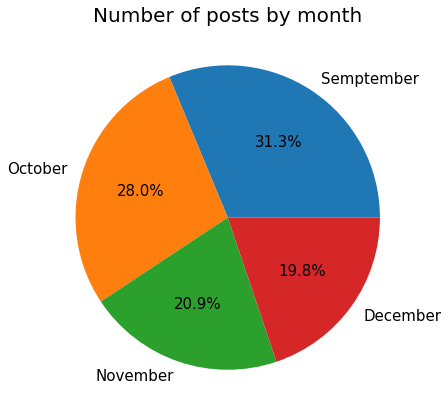

In [16]:
# pie chart
sample_df['posts_count'].plot(
    kind='pie', labels=['Semptember', 'October', 'November', 'December'], autopct='%1.1f%%', figsize=(7, 7), fontsize=15, ylabel='')
plt.title('Number of posts by month', fontdict = {'fontsize':20});

The number of posts reaches the maximum in September - 31.3% , decreases by December - 19.8%.

# Task 10

Upload the data of the user who posted the most in the entire time. Print the data for October 2008 as follows:

- week number;
- date and time of the last post published this week.

In [17]:
query = '''
SELECT DATE_PART('WEEK', creation_date)::INTEGER,
       MAX(creation_date)
FROM stackoverflow.posts
WHERE (creation_date::DATE BETWEEN '2008-10-01' AND '2008-10-31')
  AND user_id IN
    (SELECT user_id
     FROM stackoverflow.posts
     GROUP BY 1
     ORDER BY COUNT(id) DESC
     LIMIT 1)
GROUP BY 1;
'''

# query execution
sample_df = pd.read_sql_query(query, con=engine) 
sample_df

,date_part,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01


# General conclusion

<div style="border:solid green 2px; padding: 20px">

    
In this project we analyzed StackOverflow database. The version of the database contains data on posts for 2008, and the tables also provide information on later scores these posts received.

We connected to the database using Python (SQLAlchemy). Requests are stored in a `query` variable, and the output displayed as a dataframe using `pd.read_sql_query()`. For some questions, we used visualization - a heatmap for Retention Rate and a pie chart for the number of posts in a given period of time.
    
    
**Total number of page views by month in 2008.**      

The July views are much lower than in other months (669895). Most probably because the data is not presented for the whole month. The number of views reaches its peak in September (452928568) and then goes down in December (197792841). Probably a lot of employees and students leave the summer holidays and visit the site more actively. The decline in December may be due to vacation time.
    

**The most active users: more than 100 answers in the first month after registration (including day of registration).**    

Anomalies detected - repetitions in user names - i.e. one name corresponds to several IDs. This indicates that registration does not require a unique user name and can be repeated. In this case, when counting active users, the counting should be perfomed by unique ID number, not by names.

**Number of posts in 2008 from users who registered in September 2008 and made at least one post in December.**    

Data is presented from August to December. We chose users who registered in August, so the low number of posts (32) observed in this month. The number of posts increases in September and October, and decreases in November and December, reflecting the posts trend we observed earlier.

**Average number of posts in August 2008 for users who published more than 120 posts for a given month (excluding days without publication).**   

Maximum - 7.2 posts daily (ID 383), minimum - 4.7 (ID 116).    

**User interaction from 1 to 7 December 2008 with  at least one publication (question or answer).**     
On average, users interacted with the platform for two days per week (only the days when the user published a question or answer were counted). It is a good result, given that we did not analyze data about possible views, when the user also interact with the platform.  

**Retention Rate: cohorts by month of the first publication, activity by the post in the current month.**   

In the July cohort, the RR ranges from 33.33 to 66.67 (although this parameter should decline) because in October and December, the number of posts increased. In this case, for activity parameter is better to take the date of the user’s visit, because the post parameter does not reflect the full interaction with the platform. Also, the July cohort is very small (only 3 users) and not quite suitable for the RR analysis. For the rest of the cohort, retention decreases naturally throughout the cohort’s lifetime. There was also a decline in the cohort from August through December, indicating a decline in user interest in the platform over time.
    
**Number of publications from September to December.**    

The number of posts reaches the maximum in September - 31.3% , decreases by December - 19.8%.